In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from math import pi
from scipy.optimize import minimize

%matplotlib inline

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, BasicAer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor



/Users/usr0102732/src/git/qc_study/qenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


## superposition

$$
|00>  
\rightarrow
\frac{1}{2}(|00> + |01> + |10> + |11>)
$$

In [2]:
#registor
q = QuantumRegister(2, name='q')
c = ClassicalRegister(2, name='c')
qc = QuantumCircuit(q, c)

#gate operation
qc.h(q[0])
qc.h(q[1])


qc.barrier()

#測定
qc.measure(q, c)

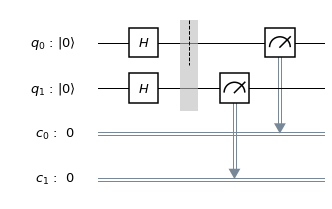

In [3]:
qc.draw(output='mpl')

In [4]:
#simulator
sim_backend = BasicAer.get_backend('qasm_simulator')

In [5]:
# シミュレータで実行
sim_job = execute(qc, backend=sim_backend , shots=1024)
result = sim_job.result()

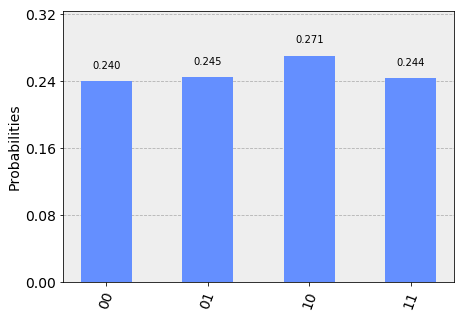

In [6]:
# 　ヒストグラム
counts = result.get_counts(qc)
plot_histogram(counts)

## IBMQ REAL QC

In [7]:
# あらかじめaccountを取得しておく必要があり
IBMQ.load_accounts()

In [8]:
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [9]:
real_backend = IBMQ.get_backend('ibmqx4')

In [10]:
real_job = execute(qc, backend=real_backend , shots=1024)

In [11]:
job_monitor(real_job)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

In [ ]:
result = real_job.result()

In [ ]:
# 　ヒストグラム
counts = result.get_counts(qc)
plot_histogram(counts)

# Grover DEMO

## grover 2 cubit

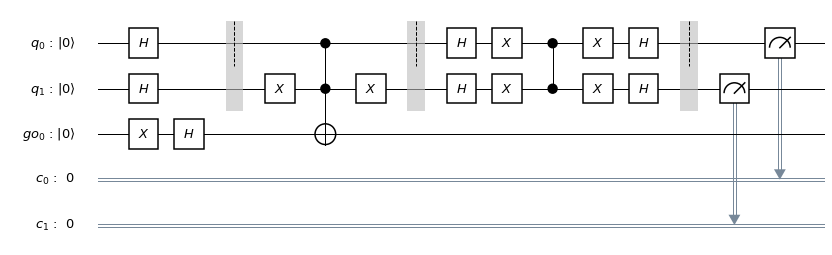

In [12]:
#register
q = QuantumRegister(2, name='q')
go = QuantumRegister(1, name='go')
c = ClassicalRegister(2,name='c')
qc = QuantumCircuit(q,go,c)

#initial superposition
qc.h(q[0])
qc.h(q[1])
qc.x(go)
qc.h(go)

qc.barrier()

# minus for target
qc.x(q[1])
qc.ccx(q[0],q[1],go[0])
qc.x(q[1])

qc.barrier()

#inversion along the mean
qc.h(q[0])
qc.h(q[1])
qc.x(q[0])
qc.x(q[1])
qc.cz(q[0],q[1])
qc.x(q[0])
qc.x(q[1])
qc.h(q[0])
qc.h(q[1])
qc.barrier()

#measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])

qc.draw(output='mpl')

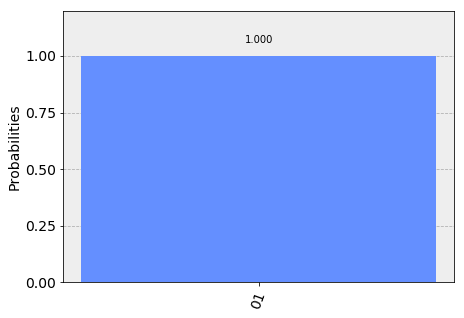

In [13]:
# Execute circuit

job = execute(qc, backend=sim_backend , shots=1024)
result = job.result()

# Get counts and plot histogram
counts = result.get_counts(qc)
plot_histogram(counts)

## groover 3 qubit

In [14]:
def multi_cnot(circ, controlled, target, aux, n):
    if n == 2:
        circ.ccx(controlled[0], controlled[1], target[0])  
        return 
    
    circ.ccx(controlled[0], controlled[1], aux[0])
    for i in range(n-3):
        circ.ccx(controlled[i+2], aux[i], aux[i+1]) 
    circ.ccx(controlled[n-1],aux[n-3], target[0])   
    for i in reversed(range(n-3)):
        circ.ccx(controlled[i+2], aux[i], aux[i+1]) 
    circ.ccx(controlled[0], controlled[1], aux[0]) 

In [15]:
# target の符号をマイナス
def target_flip(circ, qr, go, aux,  n, target_str):
    for i in range(n):
        if  target_str[n-1-i] == "0":
            circ.x(qr[i])
            
    multi_cnot(circ, qr, go, aux, n)
        
    for i in range(n):
        if  target_str[n-1-i] == "0":
            circ.x(qr[i])
    circ.barrier()

In [16]:
# 平均まわり回転
def inversion_along_mean(circ, qr,  aux,  n):
    for i in range(n):
        circ.h(qr[i])
        circ.x(qr[i])
        
    cqr = [qr[i] for i in range(n-1)]
    tqr = [qr[n-1]]
    circ.h(tqr[0]) 
  
    multi_cnot(circ, cqr,  tqr,  aux, n-1) 
    circ.h(tqr[0])
    
    for i in range(n):
        circ.x(qr[i])
        circ.h(qr[i])
        
    circ.barrier()

In [17]:
def make_circuit_groover_manual(n, target, oper_times):
    q = QuantumRegister(N, name='q')
    c = ClassicalRegister(N,name='c')
    aux = QuantumRegister(N-2,name='aux')
    go = QuantumRegister(1,name='go')
    qc = QuantumCircuit(q,aux,go, c)

    #重ね合わせ
    qc.h(q)
    
    qc.x(go)
    qc.h(go)

    qc.barrier()

                                
    for _ in range(oper_times):
        target_flip(qc, q,  go, aux,  N, target) #ターゲットのみ反転
        inversion_along_mean(qc, q,  aux, N) #平均値周り回転

    for i in range(N):
        qc.measure(q[i], c[i])
    return qc

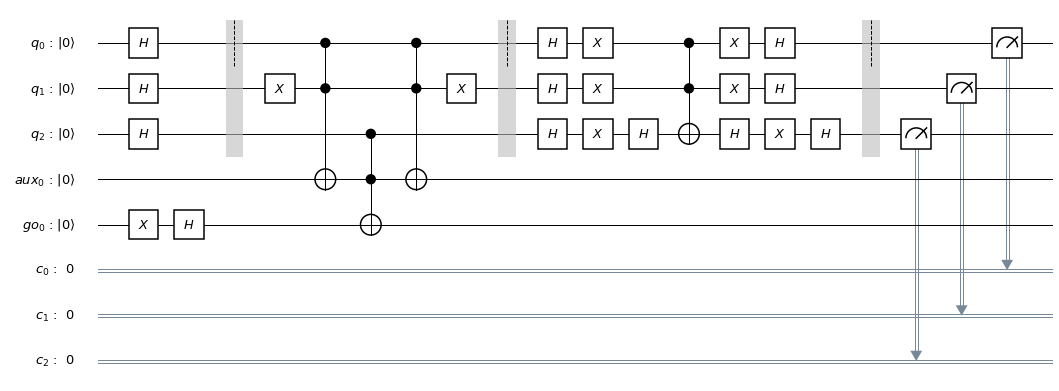

In [18]:
N = 3
target = "101"
qc = make_circuit_groover_manual(N, target, 1)
qc.draw(output='mpl')

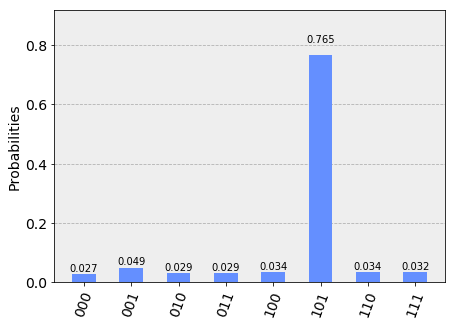

In [19]:
job = execute(qc, backend=sim_backend , shots=1024)
result = job.result()

# Get counts and plot histogram
counts = result.get_counts(qc)
plot_histogram(counts)

## groover 4 qubit

In [20]:
N = 4
target = "0100"
qc = make_circuit_groover_manual(N, target, 1)

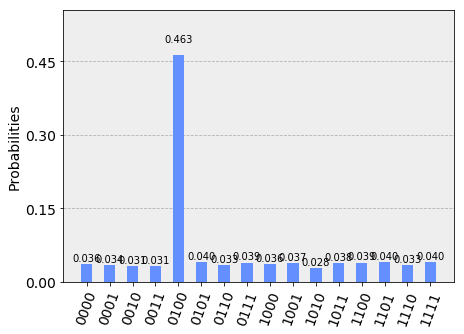

In [21]:
job = execute(qc, backend=sim_backend , shots=1024)
result = job.result()

# Get counts and plot histogram
counts = result.get_counts(qc)
plot_histogram(counts)

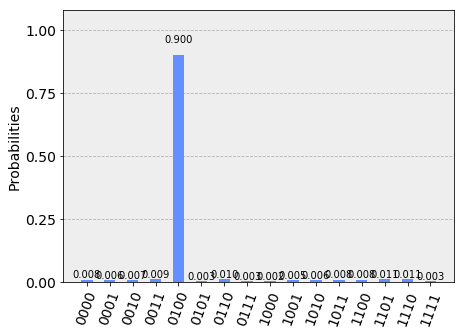

In [23]:
qc = make_circuit_groover_manual(N, target, 2)
job = execute(qc, backend=sim_backend, shots=1000)
result = job.result()

# Get counts and plot histogram
counts = result.get_counts(qc)
plot_histogram(counts)

# Classification Demo

In [24]:
def gen_xor(num_points, delta):
    Ndata = int(num_points/2) # Number of data points per point group
    delta = pi/10 # range of perturbation
    group0 = [[-pi/2 + np.random.uniform(-delta, delta), np.random.uniform(-delta, delta)] for x in range(0, Ndata)] + \
                     [[pi/2 + np.random.uniform(-delta,delta), pi+np.random.uniform(-delta, delta)] for x in range(0, Ndata)]
    group1 = [[-pi/2 + np.random.uniform(-delta,delta),pi+np.random.uniform(-delta, delta)] for x in range(0, Ndata)] + \
                     [[pi/2 + np.random.uniform(-delta,delta), np.random.uniform(-delta, delta)] for x in range(0, Ndata)]
    return [(x, 0) for x in group0] + [(x, 1) for x in group1]

In [25]:
# XOR　データの生成
XOR_TRAINING_DATA = gen_xor(20, pi/4.)

(-1, 4)

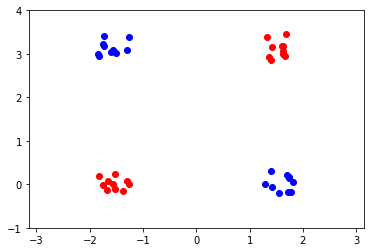

In [26]:
# XOR　データの図示
group0 = [x[0] for x in XOR_TRAINING_DATA if x[1]==0]
group1 = [x[0] for x in XOR_TRAINING_DATA if x[1]==1] 

plt.scatter([x[0] for x in group0], [x[1] for x in group0], c="r")
plt.scatter([x[0] for x in group1], [x[1] for x in group1], c="b")
plt.xlim([-pi, pi])
plt.ylim([-1,4])


In [27]:
# 分類回路の作成
def make_circuit(inputs, params):
    q = QuantumRegister(2, "q")
    c = ClassicalRegister(1, "c")
    qc = QuantumCircuit(q, c,  name="qc")

    #input 
    qc.rx(inputs[0], q[0])
    qc.rx(inputs[1], q[1])

    #calculate
    qc.cz(q[0], q[1])
    qc.rx(params[0], q[0])
    qc.rx(params[1], q[1])


    qc.measure(q[0], c[0])
    return qc

In [28]:
init_params = [3.0672044712460114, 3.3311348339721203]
init_inputs = [1.0, 1.0]

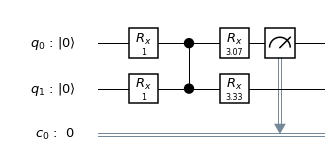

In [29]:
tmp_qc = make_circuit(init_inputs, init_params)
tmp_qc.draw(output='mpl')

In [30]:
# label=1の期待値の計算
def calc_one_prob(circ, num_shots=1024):
        job = execute(circ, backend=sim_backend, shots=num_shots, seed=20) 
        result = job.result()
        counts = result.get_counts()
        count_one = counts["1"] if "1" in counts else 0
        return float(count_one) / num_shots

In [31]:
# color_map図示
def show_cmap(params):
    rangex = np.linspace(-np.pi, np.pi, 5)
    rangey = np.linspace(-1, 4, 5)
    func_vals = []

    for y in rangey:
        for x in rangex:
            qc = make_circuit([x, y], params)
            prob = calc_one_prob(qc)
            func_vals.append(prob)
        

    X, Y = np.meshgrid(rangex, rangey)
    Z = np.reshape(func_vals, [5, 5])

    levels = np.arange(-3.5, 3.5, 0.1)
    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn
    plt.contourf(X, Y, Z, levels, cmap=cm.get_cmap(cmap, len(levels) - 1), norm=norm)

    group0 = [x[0] for x in XOR_TRAINING_DATA if x[1]==0]
    group1 = [x[0] for x in XOR_TRAINING_DATA if x[1]==1] 

    plt.scatter([x[0] for x in group0], [x[1] for x in group0], c="r")
    plt.scatter([x[0] for x in group1], [x[1] for x in group1], c="b")

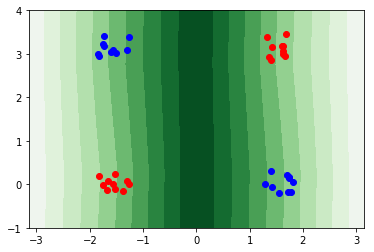

In [32]:
show_cmap(init_params)

In [33]:
def cross_entropy(predictions, targets, epsilon=1e-10):
    ce = - np.sum(np.log(predictions) * targets) / len(predictions)
    return ce

In [34]:
def target_func(param):
    preds = []
    targets = []
    for x, label in XOR_TRAINING_DATA:
        qc = make_circuit(x, param) # generate circuit
        prob = calc_one_prob(qc)  # calc output
        preds.append([1 - prob, prob]) 
        targets.append([1 - label, label])
    ce = cross_entropy(preds, targets)   #calc cross_entropy
    return ce

In [35]:

init_simplex = [init_params]
for x in range(0, len(init_params)):
    perturbed_params = [y+np.random.uniform(-np.pi, np.pi) for y in init_params]
    init_simplex = init_simplex + [perturbed_params]

loss_params = []
def callback_func(input_params):
    loss = target_func(input_params)
    loss_params.append((input_params, loss))
    print("Iter{}: Loss:{}".format(len(loss_params), loss))
    


In [36]:
#最適化
res = minimize(target_func, init_params, args=(), callback=callback_func,  method='Nelder-Mead', tol=1e-2,
               options={'disp': True, 'initial_simplex': init_simplex, 'xatol': 1e-3, 'return_all': False, 'fatol': 1e-3, 'maxiter': 10})

Iter1: Loss:0.018861559536013123
Iter2: Loss:0.018861559536013123
Iter3: Loss:0.018861559536013123
Iter4: Loss:0.014697320136019685
Iter5: Loss:0.014697320136019685


/Users/usr0102732/src/git/qc_study/qenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/usr0102732/src/git/qc_study/qenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


Iter6: Loss:0.014697320136019685
Iter7: Loss:0.014673478295034148
Iter8: Loss:0.014313698975274385
Iter9: Loss:0.014313698975274385


In [37]:
res

 final_simplex: (array([[1.5200895 , 4.08181557],
       [1.51888543, 3.9597951 ],
       [1.49772255, 4.0339562 ]]), array([0.0143137 , 0.01433876, 0.01467348]))
           fun: 0.014313698975274385
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 25
           nit: 10
        status: 2
       success: False
             x: array([1.5200895 , 4.08181557])

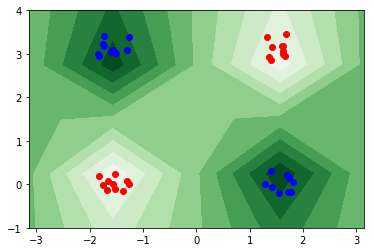

In [38]:
show_cmap(res.x)